<a href="https://colab.research.google.com/github/jg4726/public-file/blob/main/Timeseries_Classification_Hyper_Parameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
from pandas import DataFrame
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [ ]:
#1. Arima

df = pd.read_csv("assignment_1.csv",parse_dates=["date"])

In [ ]:
df_gold = df.loc[:,'gold_price']
df_gold

0       299.1
1       303.9
2       316.4
3       316.5
4       329.8
        ...  
291    1320.1
292    1300.9
293    1284.0
294    1359.0
295    1498.8
Name: gold_price, Length: 296, dtype: float64

In [ ]:
acf(df_gold,adjusted =False,fft=False)

array([1.        , 0.98966998, 0.98093658, 0.97264185, 0.96415165,
       0.95419753, 0.94412769, 0.93566639, 0.9275161 , 0.91937546,
       0.90993731, 0.89980968, 0.88913582, 0.87729124, 0.86439648,
       0.85270171, 0.84043013, 0.82802308, 0.81468853, 0.80237249,
       0.79029717, 0.77824754, 0.76649944, 0.75425206, 0.74490316,
       0.73468277, 0.72420545, 0.71218087, 0.70063263, 0.69041245,
       0.67892978, 0.66644117, 0.65572274, 0.64662196, 0.63553202,
       0.62524078, 0.61556976, 0.60682237, 0.59733481, 0.58699425,
       0.57539161])

In [ ]:
pacf(df_gold)

array([ 1.        ,  0.99302479,  0.10871823,  0.03946478, -0.01128656,
       -0.11557813, -0.04296564,  0.10143302,  0.04825964,  0.02419333,
       -0.10213845, -0.11371211, -0.09077994, -0.10636564, -0.08672238,
        0.08961237, -0.03329561, -0.02649309, -0.10855851,  0.00503102,
        0.01407202,  0.04993534,  0.07369506, -0.01307693,  0.21184918,
       -0.01135772, -0.01348791, -0.1460231 , -0.04672237,  0.12802318,
       -0.01650466, -0.08837611,  0.07415652,  0.06989881, -0.21400497,
        0.02485521,  0.0127637 ,  0.07203833,  0.05271444, -0.0982127 ,
       -0.19349011])

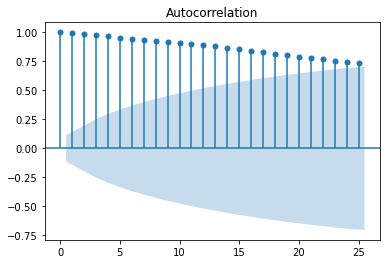

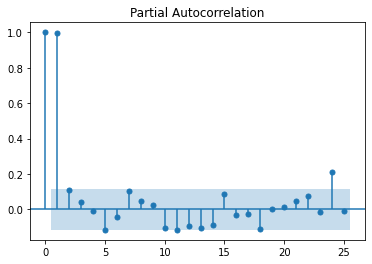

In [ ]:
beforediff_acf = plot_acf(df_gold)
beforediff_pacf = plot_pacf(df_gold) 

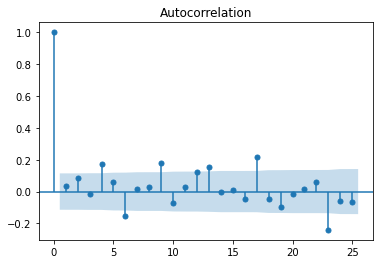

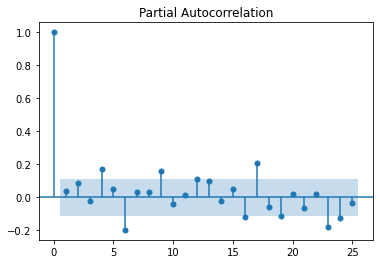

In [ ]:
##c. The acf is slowly decaying which indicates that this time series are not stationary
##   Pacf on the other hand has spikes in lag 1
##d. 
first_diff = df_gold.diff()[1:]

afterdiff_acf= plot_acf(first_diff)
afterdiff_pacf = plot_pacf(first_diff)
##   so ARMA is (1,1)

In [ ]:
#e. Yes it shows negative correlation
db_w = durbin_watson(first_diff)
db_w

1.8581450795228833

In [ ]:
#f
model = ARMA(first_diff,order=(1,1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             gold_price   No. Observations:                  295
Model:                     ARMA(1, 1)   Log Likelihood               -1486.750
Method:                       css-mle   S.D. of innovations             37.367
Date:                Tue, 29 Mar 2022   AIC                           2981.500
Time:                        01:59:20   BIC                           2996.248
Sample:                             0   HQIC                          2987.406
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.4383      3.384      1.311      0.190      -2.195      11.071
ar.L1.gold_price     0.9118      0.077     11.896      0.000       0.762       1.062
ma.L1.gold_price    -0.8615 

Statistics=-27585332.046, p=1.000
it is normally distributed


<AxesSubplot:ylabel='Density'>

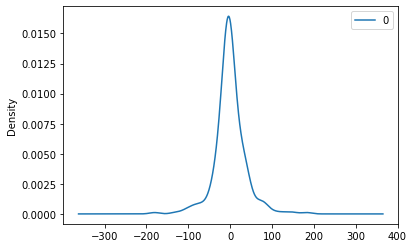

In [ ]:
#g
from scipy.stats import chisquare
from scipy import stats
resi = DataFrame(model_fit.resid)
stat, p = chisquare(resi)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('it is normally distributed')
else:
	print('not normally distributed')

resi.plot(kind='kde')


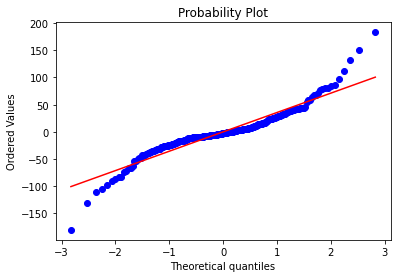

In [ ]:
import pylab
import scipy.stats as stats

new_resi = resi.values.flatten()
stats.probplot(new_resi,dist='norm',plot=pylab)
pylab.show()

In [ ]:
#h. Yes it has improved
import statsmodels.api as sm
res = sm.tsa.ARMA(first_diff, (2,1)).fit(disp=-1)
sm.stats.acorr_ljungbox(res.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,31.715887,0.000446


Text(0, 0.5, 'differences')

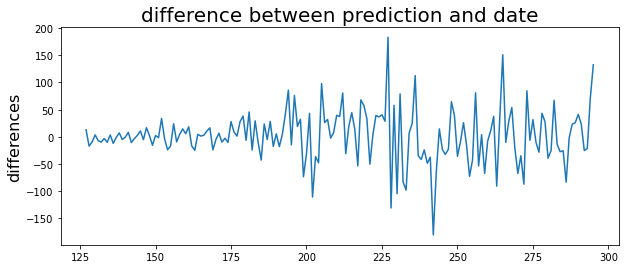

In [ ]:
#i
df_gold = df.loc[:,['date','gold_price']]
before_2k = df_gold[df_gold["date"] < pd.to_datetime("2000-01-01")]
after_2k = df_gold[df_gold["date"] >= pd.to_datetime("2000-01-01")]

train_diff= np.diff(before_2k.loc[:,"gold_price"], n=1)
test_diff=np.diff(after_2k.loc[:,"gold_price"], n=1)

new_model = ARMA(train_diff,order=(1,1))
new_model_fit = model.fit()

predict = new_model_fit.predict(start = after_2k.index[0], end= after_2k.index[-2])


#predict
residuals = test_diff - predict
plt.figure(figsize=(10,4))

plt.plot(residuals)


plt.title('difference between prediction and date', fontsize=20)
plt.ylabel('differences', fontsize=16)



In [ ]:
#j
print('MAE =:', np.mean(abs(residuals)))
print('MFE =:', np.mean(residuals))

MAE =: 33.8487317355554
MFE =: 2.216420528608618


In [ ]:
#2. Classification

df_3 = pd.read_csv("assignment_3.csv")

df_3.isna().sum()
df_3= df_3.loc[df_3.mass_shape.notna(),:]
df_3= df_3.loc[df_3.mass_margins.notna(),:]

In [ ]:
df_3= df_3.drop(['mass_shape','mass_margins'],axis = 'columns')

In [ ]:
df_3 = df_3[df_3['pathology'].isin(['BENIGN','MALIGNANT'])]

In [ ]:
#2. Classification

from sklearn.preprocessing import LabelEncoder

#b
inputs = df_3
le_lr = LabelEncoder()
le_iv =LabelEncoder()
le_abid =LabelEncoder()
le_abty =LabelEncoder()
le_bd =LabelEncoder()
le_pa =LabelEncoder()


inputs['lr'] = le_lr.fit_transform(inputs['left_or_right_breast'])
inputs['iv'] = le_iv.fit_transform(inputs['image_view'])
inputs['abid'] = le_abid.fit_transform(inputs['abnormality_id'])
inputs['abty'] = le_abty.fit_transform(inputs['abnormality_type'])
inputs['bd'] = le_bd.fit_transform(inputs['breast_density'])
inputs['pathology'] = le_pa.fit_transform(inputs['pathology'])

new_in = inputs.drop(['left_or_right_breast','image_view','abnormality_id','abnormality_type','breast_density'],axis='columns')


from sklearn.model_selection import train_test_split

train, test = train_test_split(new_in, test_size=0.25)

train_y = train.pathology
train_x= train.drop(['pathology'],axis = 'columns')

test_y = test.pathology
test_x= test.drop(['pathology'],axis = 'columns')


from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy')
model = model.fit(train_x,train_y)
pred_y = model.predict(test_x)


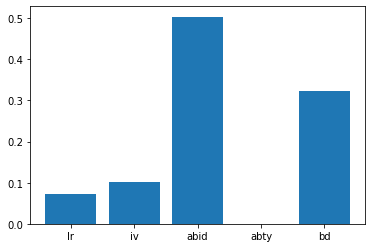

In [ ]:
#f
from matplotlib import pyplot
importance = model.feature_importances_
pyplot.bar([x for x in train_x.columns], importance)
pyplot.show()

In [ ]:
#g
from sklearn import metrics

metrics.accuracy_score(test_y, pred_y)

0.5052083333333334

In [ ]:
#3. Hyper-Parameter Optimization
#a 
param_list = {"min_samples_leaf":[2,4,6,8,10,12,14,16,18,20],
           "min_samples_split":[2,3,4,5,6,7,8,9,10,11],
           "criterion":["entropy"] }
from sklearn.model_selection import GridSearchCV

model_new = model.fit(train_x,train_y)
grid_obj =  GridSearchCV(model_new ,  param_list,cv = 5)
grid_obj.fit(train_x,train_y)
grid_obj.best_params_
## the reason I choose this is because after using gridsearchcv the best min sample leaf is 10 and the min sample split is 2

{'criterion': 'entropy', 'min_samples_leaf': 10, 'min_samples_split': 2}

In [ ]:
#b
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)
from scipy.stats import sem
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [ ]:
def get(model, p1,p2):
    if (model == "dtc"):
        return DecisionTreeClassifier(criterion='entropy',min_samples_leaf = p1,min_samples_split = p2)
    elif(model == "lr"):
        return LogisticRegression()
    elif(model == "forest"):
        return RandomForestClassifier(n_estimators = p1, max_depth = p2)
    elif(model == "super"):
        return svm.SVC(C=p1,probability = True)
    elif(model == 'mlp'):
        return MLPClassifier(hidden_layer_sizes =p1)

def auc_results(model, p1,p2,trainx,trainy):
    auc = []

    for i in p1:
        for j in p2:
            model_new = get(model,i,j)
            model_new = model_new.fit(train_x,train_y)        
            score = cross_val_score(model_new,trainx,trainy,cv = 5,scoring = "roc_auc")
            auc += [np.mean(score)- np.std(score)/np.sqrt(np.size(score))]   
    return auc
    
    
min_leaf = [2,4,6,8,10,12,14,16,18,20]
min_split = [2,3,4,5,6,7,8,9,10,11]

dtc_result = auc_results("dtc",min_leaf,min_split,train_x,train_y)
dtc_result


[0.493710356463065,
 0.493710356463065,
 0.493710356463065,
 0.493710356463065,
 0.49299422444468133,
 0.49299597660450906,
 0.49299597660450906,
 0.4941697685743556,
 0.49548201832454913,
 0.4955197600593342,
 0.4937079816768662,
 0.4937079816768662,
 0.4937079816768662,
 0.4937079816768662,
 0.4937079816768662,
 0.4937079816768662,
 0.4937079816768662,
 0.4944291156898997,
 0.4955626883061565,
 0.4955626883061565,
 0.4904826475956245,
 0.4904826475956245,
 0.4904826475956245,
 0.4904826475956245,
 0.4904826475956245,
 0.4904826475956245,
 0.4904826475956245,
 0.4904826475956245,
 0.4904826475956245,
 0.4904826475956245,
 0.4902074604366992,
 0.4902074604366992,
 0.4902074604366992,
 0.4902074604366992,
 0.4902074604366992,
 0.4902074604366992,
 0.4902074604366992,
 0.4902074604366992,
 0.4902074604366992,
 0.4902074604366992,
 0.49277646822899096,
 0.49277646822899096,
 0.49277646822899096,
 0.49277646822899096,
 0.49277646822899096,
 0.49277646822899096,
 0.49277646822899096,
 0.492

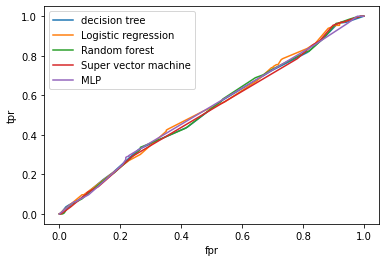

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import roc_curve
#plot everything together
tree = DecisionTreeClassifier(criterion = "entropy",min_samples_split = 10, min_samples_leaf=10).fit(train_x,train_y)
tree_pred = tree.predict_proba(test_x)[:,1]

logreg = LogisticRegression().fit(train_x,train_y)
lr_pred = logreg.predict_proba(test_x)[:,1]

rad = RandomForestClassifier().fit(train_x,train_y)
rad_pred = rad.predict_proba(test_x)[:,1]

svc = svm.SVC(probability = True).fit(train_x,train_y)
svc_pred = svc.predict_proba(test_x)[:,1]

p1=[2,4,6,8,10,12,14,16,18,20]
mlp =MLPClassifier(hidden_layer_sizes =p1).fit(train_x,train_y)
mlp_pred = mlp.predict_proba(test_x)[:,1]

plt.xlabel('fpr')
plt.ylabel('tpr')

t_fpr,t_tpr,t_thresholds = roc_curve(test_y,tree_pred)
plt.plot(t_fpr,t_tpr,label='decision tree')

lr_fpr,lr_tpr,lr_thresholds = roc_curve(test_y,lr_pred)
plt.plot(lr_fpr,lr_tpr,label='Logistic regression')

rad_fpr,rad_tpr,rad_thresholds = roc_curve(test_y,rad_pred)
plt.plot(rad_fpr,rad_tpr,label='Random forest')

svc_fpr,svc_tpr,svc_thresholds = roc_curve(test_y,svc_pred)
plt.plot(svc_fpr,svc_tpr,label='Super vector machine')

mlp_fpr,mlp_tpr,mlp_thresholds = roc_curve(test_y,mlp_pred)
plt.plot(mlp_fpr,mlp_tpr,label='MLP')

plt.legend()

In [ ]:
resi

In [ ]:
test_y